In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math, copy
import re

from pathlib import Path

import nltk
from nltk.corpus import stopwords
#from wordcloud import WordCloud

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack

%matplotlib inline

In [36]:
def load_files(folder_path):
    folder_path = Path(folder_path)
    dataframes = {}

    for file in folder_path.glob("*.csv"):
        dataframes[file.stem] = pd.read_csv(file)

    return dataframes


In [37]:
dataframes = load_files("/Users/user/Documents/Projects/ml_projects/ecommerce_ml_system/data/raw/olist")
orders_df = dataframes["olist_orders_dataset"]
orders_reviews_df = dataframes["olist_order_reviews_dataset"]
orders_items_df = dataframes["olist_order_items_dataset"]
orders_payments_df = dataframes["olist_order_payments_dataset"]
customers_df = dataframes["olist_customers_dataset"]
products_df = dataframes["olist_products_dataset"]
sellers_df = dataframes["olist_sellers_dataset"]
geolocation_df = dataframes["olist_geolocation_dataset"]
product_category_df = dataframes["product_category_name_translation"]

In [40]:
#np.unique(orders_df["order_status"], return_counts=True)
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [38]:
df_sorted = orders_df.sort_values("order_purchase_timestamp").reset_index(drop=True)
#X_sorted = X.loc[df_sorted.index].reset_index(drop=True)

In [39]:
df_sorted

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaN,2016-10-20 00:00:00
1,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,NaN,NaN,2016-10-28 00:00:00
2,809a282bbd5dbcabb6f2f724fca862ec,622e13439d6b5a0b486c435618b2679e,canceled,2016-09-13 15:24:19,2016-10-07 13:16:46,NaN,NaN,2016-09-30 00:00:00
3,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00
4,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02 22:07:52,2016-10-06 15:50:56,NaN,NaN,2016-10-25 00:00:00
...,...,...,...,...,...,...,...,...
99436,392ed9afd714e3c74767d0c4d3e3f477,2823ffda607a2316375088e0d00005ec,canceled,2018-09-29 09:13:03,NaN,NaN,NaN,2018-10-15 00:00:00
99437,616fa7d4871b87832197b2a137a115d2,bf6181a85bbb4115736c0a8db1a53be3,canceled,2018-10-01 15:30:09,NaN,NaN,NaN,2018-10-23 00:00:00
99438,a2ac6dad85cf8af5b0afb510a240fe8c,4c2ec60c29d10c34bd49cb88aa85cfc4,canceled,2018-10-03 18:55:29,NaN,NaN,NaN,2018-10-16 00:00:00
99439,b059ee4de278302d550a3035c4cdb740,856336203359aa6a61bf3826f7d84c49,canceled,2018-10-16 20:16:02,NaN,NaN,NaN,2018-11-12 00:00:00


In [41]:
split_idx = int(len(df_sorted) * (1 - 0.15))

In [43]:
len(df_sorted)

99441

In [46]:
final_data = pd.read_csv("../data/processed/featured_orders.csv")

In [47]:
final_data.head()

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_score,total_price,avg_item_price,min_item_price,max_item_price,...,price_delay_interaction,value_per_delivery_day,weight_distance_risk,freight_weight_efficiency,order_complexity,value_risk,handling_risk_score,distance_premium,holiday_delivery_risk,bulk_weight_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,4.0,29.99,29.99,29.99,29.99,...,0.0,3.332222,0.00,14.533333,4,29.99,0.0,0.000000,0,0.50
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,4.0,118.70,118.70,118.70,118.70,...,0.0,8.478571,0.40,45.520000,4,118.70,0.0,0.190142,0,0.40
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,5.0,159.90,159.90,159.90,159.90,...,0.0,15.990000,0.42,36.961538,4,159.90,0.0,0.119453,0,0.42
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,5.0,45.00,45.00,45.00,45.00,...,0.0,3.214286,0.45,49.454545,4,45.00,0.0,0.591304,13,0.45
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,5.0,19.90,19.90,19.90,19.90,...,0.0,6.633333,0.00,24.914286,4,19.90,0.0,0.000000,0,0.25


In [52]:
import pandas as pd
import numpy as np

import joblib
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

class ModelDataPreparator:

    def __init__(self, config_path = "config/modeling_config.yaml"):
        
        self.scalers = {}
        self.encoders = {}
        self.feature_names = None

    
    def prepare_data(self, df: pd.DataFrame, test_size=0.15, val_size=0.15, random_state=42):

        print("="*80)
        print("PREPARING DATA FOR MODELING")
        print("="*80)

        # Step 1: Separate features and target
        X, y = self.separate_features_target(df)

        # Step 2: Handle missing values
        X = self.handle_missing_values(X)

        # Step 3: Encode categorical variables
        X = self.encode_categorical_features(X)

        # Step 4: Time-based split (important for time-series data)
        X_train, X_temp, y_train, y_temp = self.time_based_split(df, X, y, test_size=test_size)

        # Split temp into validation and test
        val_ratio = val_size / (test_size + val_size)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,
                                                        random_state=random_state, stratify=y_temp)
        
        # Step 5: Scale numerical features (fit on train only!)
        X_train_scaled = self.scale_features(X_train, fit=True)
        X_test_scaled = self.scale_features(X_test, fit=False)
        X_val_scaled = self.scale_features(X_val, fit=False)

        # Store feature names
        self.feature_names = X_train_scaled.columns.tolist()

        # Create splits dictionary
        splits = {
            "X_train": X_train_scaled,
            "X_val": X_val_scaled,
            "X_test": X_test_scaled,
            "y_train": y_train,
            "y_val": y_val,
            "y_test": y_test
        }

        # Print summary
        self.print_split_summary(splits)

        return splits
    

    def separate_features_target(self, df: pd.DataFrame):
        """ Separate features and target, drop unnecessary columns """

        # Columns to drop (not features)
        drop_columns = [
            "order_id",                          # Identifier
            "customer_id",                       # Identifier
            "primary_seller_id",                 # Identifier
            "order_purchase_timestamp",          # Raw timestamp
            "order_delivered_customer_date",     # Raw timestamp (used for target)
            "order_estimated_delivery_date",     # Raw timestamp
            "is_low_quality",                    # Target variable
            "review_score",                      # Used to create target
            "delivery_delay_days"                # Used to create target
        ]

        # Drop columns that exist in dataframe
        drop_columns = [col for col in drop_columns if col in df.columns]

        # Separate target
        y = df["is_low_quality"].copy()

        # Separate features
        X = df.drop(columns=drop_columns)

        print(f"   Features: {X.shape[1]} columns")
        print(f"   Target: {y.name}")
        print(f"   Samples: {len(X):,}")

        return X, y
    

    def handle_missing_values(self, X: pd.DataFrame):
        """ Handle missing values in features """
        print("\n[2/5] Handling missing values...")

        missing_before = X.isnull().sum().sum()

        # Numerical columns: fill with median
        numerical_cols = X.select_dtypes(include=[np.number]).columns #select only numeric columns (int, float, etc.) and .columns - get their names as a list/index
        for col in numerical_cols:
            if X[col].isnull().sum() > 0:
                median_val = X[col].median()
                X[col] = X[col].fillna(median_val) # Replace all NaN in that column with the median value.
                print(f"   Filled {col} with median: {median_val:.2f}")

        # Categorical columns: fill with 'unknown'
        categorical_cols = X.select_dtypes(include=["object", "category"]).columns
        for col in categorical_cols:
            if X[col].isnull().sum() > 0:
                X[col] = X[col].fillna("unknown")
                print(f"   Filled {col} with 'unknown'")

        missing_after = X.isnull().sum().sum()

        print(f"   Missing values before: {missing_before}")
        print(f"   Missing values after: {missing_after}")

        return X
    

    def encode_categorical_features(self, X: pd.DataFrame):
        """ Encode Categorical Features """

        categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist() # Give me all columns that are categorical in nature — either stored as strings (object) or as pandas categorical type (category)
        print(f"   Found {len(categorical_cols)} categorical columns")

        for col in categorical_cols:
            # Check number of unique values
            n_unique = X[col].nunique()

            if n_unique <= 10:
                # One-hot encode (for low cardinality)
                print(f"   One-hot encoding: {col} ({n_unique} categories)")
                dummies = pd.get_dummies(X[col], prefix=col, drop_first=True)
                X = pd.concat([X, dummies], axis=1)
                X = X.drop(columns=col)

            else:
                # Label encode (for high cardinality)
                print(f"   Label encoding: {col} ({n_unique} categories)")
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
                self.encoders[col] = le

        print(f"   Final feature count: {X.shape[1]}")
        return X
    
    
    def time_based_split(self, df: pd.DataFrame, X: pd.DataFrame, y: pd.Series, test_size=0.15):
        print("\n[4/5] Creating time-based train/test split...")

        # Sort by purchase timestamp
        if "order_purchase_timestamp" in df:
            df_sorted = df.sort_values("order_purchase_timestamp").reset_index(drop=True)
            X_sorted = X.loc[df_sorted.index].reset_index(drop=True)
            y_sorted = y.loc[df_sorted.index].reset_index(drop=True) # Make sure features X and target y are in the same chronological order as the orders.

            # Split at time cutoff
            split_idx = int(len(df_sorted) * (1 - test_size))

            X_train = X_sorted.iloc[:split_idx]
            X_temp = X_sorted.iloc[split_idx:]
            y_train = y_sorted.iloc[:split_idx]
            y_temp = y_sorted.iloc[split_idx:]

            print(f"   Time-based split at index: {split_idx}")

        else:
            # Fallback to random split if no timestamp
            print("   Warning: No timestamp found, using random split")
            X_train, X_temp, y_train, y_temp = train_test_split(
                X, y, test_size=test_size, random_state=42, stratify=y
            )

        return X_train, X_temp, y_train, y_temp

    
    def scale_features(self, X: pd.DataFrame, fit=False):

        print("\n[5/5] Scaling features (fitting on training data)...")
        numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

        # Don't scale binary features (0/1)
        binary_cols = []
        for col in numerical_cols:
            if X[col].nunique() == 2 and set(X[col].unique()).issubset({0,1}):
                binary_cols.append(col)

        cols_to_scale = [col for col in numerical_cols if col not in binary_cols]

        # Replace inf/-inf → NaN
        X[cols_to_scale] = X[cols_to_scale].replace([np.inf, -np.inf], np.nan)
        # Impute NaNs
        X[cols_to_scale] = X[cols_to_scale].fillna(X[cols_to_scale].median())

        if fit:
            print(f"   Scaling {len(cols_to_scale)} numerical features")
            print(f"   Keeping {len(binary_cols)} binary features unscaled")
  
            # Fit scaler
            scaler = StandardScaler()
            X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
            self.scalers["standard"] = scaler
            self.scalers["columns"] = cols_to_scale

        else:
            # Transform using fitted scaler
            scaler = self.scalers['standard']
            cols_to_scale = self.scalers['columns']
            X[cols_to_scale] = scaler.transform(X[cols_to_scale])
        
        return X
    

    def print_split_summary(self, splits):
        """ Print summary of data splits """
        print("\n" + "="*80)
        print("DATA SPLIT SUMMARY")
        print("="*80)
        
        print(f"\nTrain set: {len(splits['X_train']):,} samples")
        print(f"  Low quality: {splits['y_train'].sum():,} ({splits['y_train'].mean()*100:.2f}%)")
        print(f"  Good quality: {(~splits['y_train'].astype(bool)).sum():,} ({(1-splits['y_train'].mean())*100:.2f}%)")
        
        print(f"\nValidation set: {len(splits['X_val']):,} samples")
        print(f"  Low quality: {splits['y_val'].sum():,} ({splits['y_val'].mean()*100:.2f}%)")
        print(f"  Good quality: {(~splits['y_val'].astype(bool)).sum():,} ({(1-splits['y_val'].mean())*100:.2f}%)")
        
        print(f"\nTest set: {len(splits['X_test']):,} samples")
        print(f"  Low quality: {splits['y_test'].sum():,} ({splits['y_test'].mean()*100:.2f}%)")
        print(f"  Good quality: {(~splits['y_test'].astype(bool)).sum():,} ({(1-splits['y_test'].mean())*100:.2f}%)")
        
        print(f"\nFeatures: {len(self.feature_names)}")


    def save_preprocessing_objects(self, save_dir="models/preprocessing"):
        """ Save scalers and encoders for later use """

        Path(save_dir).mkdir(parents=True, exist_ok=True)

        # Save Scalers
        if self.scalers:
            joblib.dump(self.scalers, f"{save_dir}/scalers.plk")

        # Save Encoders
        if self.encoders:
            joblib.dump(self.encoders, f"{save_dir}/encoders.plk")

        # Save Feature Names
        if self.feature_names:
            with open(f"{save_dir}/feature_names.json", "w") as f:
                json.dump(self.feature_names, f)

        print(f"\n Saved preprocessing objects to {save_dir}/")


def prepare_modeling_data(df_path="../data/processed/featured_orders.csv"):

        # Load data
    df = pd.read_csv(df_path, parse_dates=[
            "order_purchase_timestamp",
            "order_delivered_customer_date",
            "order_estimated_delivery_date"
        ])

    # Prepare data
    preparator = ModelDataPreparator()
    splits = preparator.prepare_data(df)

    # Save preprocessing objects
    #preparator.save_preprocessing_objects()

    return splits, preparator
    

if __name__ == "__main__":
    splits, preparator = prepare_modeling_data()


PREPARING DATA FOR MODELING
   Features: 103 columns
   Target: is_low_quality
   Samples: 95,560

[2/5] Handling missing values...
   Filled avg_weight_g with median: 700.00
   Filled max_weight_g with median: 700.00
   Filled avg_length_cm with median: 25.00
   Filled avg_height_cm with median: 13.00
   Filled avg_width_cm with median: 20.00
   Filled avg_photos_qty with median: 2.00
   Filled avg_weight_kg with median: 0.70
   Filled max_weight_kg with median: 0.70
   Filled bulk_weight_score with median: 0.75
   Filled weight_category with 'unknown'
   Missing values before: 1472
   Missing values after: 0
   Found 13 categorical columns
   Label encoding: primary_category (72 categories)
   Label encoding: customer_city (4081 categories)
   Label encoding: customer_state (27 categories)
   Label encoding: seller_city (591 categories)
   Label encoding: seller_state (22 categories)
   One-hot encoding: primary_payment_type (4 categories)
   One-hot encoding: season (4 categories)
 

In [54]:
splits, preparator = prepare_modeling_data("../data/processed/featured_orders.csv")

PREPARING DATA FOR MODELING
   Features: 103 columns
   Target: is_low_quality
   Samples: 95,560

[2/5] Handling missing values...
   Filled avg_weight_g with median: 700.00
   Filled max_weight_g with median: 700.00
   Filled avg_length_cm with median: 25.00
   Filled avg_height_cm with median: 13.00
   Filled avg_width_cm with median: 20.00
   Filled avg_photos_qty with median: 2.00
   Filled avg_weight_kg with median: 0.70
   Filled max_weight_kg with median: 0.70
   Filled bulk_weight_score with median: 0.75
   Filled weight_category with 'unknown'
   Missing values before: 1472
   Missing values after: 0
   Found 13 categorical columns
   Label encoding: primary_category (72 categories)
   Label encoding: customer_city (4081 categories)
   Label encoding: customer_state (27 categories)
   Label encoding: seller_city (591 categories)
   Label encoding: seller_state (22 categories)
   One-hot encoding: primary_payment_type (4 categories)
   One-hot encoding: season (4 categories)
 

In [55]:
splits

{'X_train':        total_price  avg_item_price  min_item_price  max_item_price  price_std  \
 0        -0.510782       -0.504708       -0.501641       -0.506454  -0.067109   
 1        -0.086179       -0.033343       -0.030012       -0.037019  -0.067109   
 2         0.111021        0.185576        0.189029        0.181003  -0.067109   
 3        -0.438938       -0.424951       -0.421840       -0.427024  -0.067109   
 4        -0.559077       -0.558322       -0.555285       -0.559848  -0.067109   
 ...            ...             ...             ...             ...        ...   
 81221    -0.224028       -0.186373       -0.183128       -0.189422  -0.067109   
 81222    -0.625656       -0.632233       -0.629238       -0.633457  -0.067109   
 81223    -0.379156       -0.358585       -0.355437       -0.360929  -0.067109   
 81224     0.776332        0.130049       -0.076797        0.334995   4.172278   
 81225    -0.128348       -0.080155       -0.076850       -0.083639  -0.067109   
 
   

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve
)

models = {}
results = {}

lr_basic = LogisticRegression(max_iter=1000, random_state=42)
lr_basic.fit(splits["X_train"], splits["y_train"])


# Train with class weights
lr_balanced = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
lr_balanced.fit(splits["X_train"], splits["y_train"])


models["lr_basic"] = lr_basic
models["lr_balanced"] = lr_balanced


In [60]:
lr_balanced.score(splits["X_test"], splits["y_test"])

0.8336821543184038

In [61]:
# Predictions
y_pred = lr_balanced.predict(splits["X_test"])
y_pred_proba = lr_balanced.predict_proba(splits["X_test"])[:, 1]

In [64]:
acc_lr = sum(y_pred == splits["y_test"]) / len(y_pred)
acc_lr

0.8336821543184038

In [65]:
accuracy_score_lr = accuracy_score(splits["y_test"], y_pred)
accuracy_score_lr

0.8336821543184038

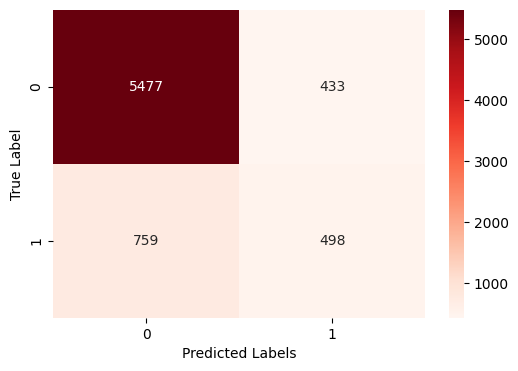

In [67]:
cm = confusion_matrix(y_pred, splits["y_test"])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Labels")
plt.ylabel("True Label")
plt.show()

In [32]:
test_df = pd.DataFrame({
    "A": [10, 20, 30, 40, 55, 60, 80],
    "B": [40, 50, 60, 90, 34, 20, 60],
    "C": [35, 40, 70, 56, 49, 30, 70],
    "D": [30, 50, 75, 50, 40, 29, 70],
    "E": [40, 70, 65, 60, 50, 40, 80]
})

#test_df = pd.DataFrame({
 #   "A": [10, 20, 30],
  #  "B": [40, 50, 60],
   # "C": [35, 40, 70],
    #"D": [30, 50, 75],
    #"E": [40, 70, 65]
#}, index=[100, 101, 102])

In [33]:

# Select row with index label 101
test_df.iloc[:, 2:6]
# Output: A 20, B 50

In [34]:
# Select rows 100 and 101
test_df.loc[100:102]

In [30]:
split_idx = int(len(df_sorted) * (1 - test_size))

,A,B
100,10,40
101,20,50
102,30,60


In [11]:
product_category_df.head(2)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories


In [12]:
orders_reviews_df.head(2)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13


In [ ]:
#Percentage of missing values

missing_pct = orders_df.isna().mean() * 100
missing_pct = missing_pct.sort_values(ascending=False)

missing_pct

In [ ]:
missing_summary = pd.DataFrame({
    "missing_count": orders_df.isna().sum(),
    "missing_percentage": orders_df.isna().mean() * 100
}).sort_values("missing_percentage", ascending=False)

missing_summary


In [ ]:
# Check if the primary key has duplicate row. Primary key should be the same number as the df shape
orders_df.nunique()

In [ ]:
orders_df.order_status.unique()

In [ ]:
orders_df.order_status.value_counts()

In [ ]:
orders_df.order_status.value_counts(normalize=True)*100

In [ ]:
# Drop other rows. Only need the orders delivered for this model

orders_df = orders_df.loc[orders_df["order_status"] == "delivered"]

In [ ]:
orders_df.shape

In [ ]:
orders_df.order_purchase_timestamp.min()

In [ ]:
orders_df.order_purchase_timestamp.max()

In [ ]:
orders_df["order_purchase_timestamp"] = pd.to_datetime(orders_df["order_purchase_timestamp"], format="%Y-%m-%d %H:%M:%S")

In [ ]:
# Create a Year-Month column
orders_df["order_year_month"] = orders_df["order_purchase_timestamp"].dt.to_period("M")

In [ ]:
# Count orders by month
orders_per_month = orders_df.groupby("order_year_month").size().reset_index(name="order_count")
orders_per_month

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(orders_per_month["order_year_month"].astype(str), 
         orders_per_month["order_count"], marker='o')
plt.xticks(rotation=45)
plt.title("OOrders per Month")
plt.xlabel("Year-Month")
plt.ylabel("Number of Orders")
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(12,6))
plt.bar(orders_per_month["order_year_month"].astype(str), 
        orders_per_month["order_count"], color='skyblue')
plt.xticks(rotation=45)
plt.title("Orders per Month")
plt.xlabel("Year-Month")
plt.ylabel("Number of Orders")
plt.show()


In [ ]:
orders_df["order_weekday_name"] = orders_df["order_purchase_timestamp"].dt.day_name()

In [ ]:
# Count orders per week day
orders_per_weekday = orders_df.groupby("order_weekday_name").size().reset_index(name="order_count")

# To order days properly (Monday - Sunday)
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
orders_per_weekday["order_weekday_name"] = pd.Categorical(orders_per_weekday["order_weekday_name"], categories=weekday_order, ordered=True)
orders_per_weekday = orders_per_weekday.sort_values("order_weekday_name")
orders_per_weekday

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(orders_per_weekday["order_weekday_name"], orders_per_weekday["order_count"], color='skyblue')
plt.title("Orders by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Orders")
plt.show()


In [ ]:
orders_df["order_hour"] = orders_df["order_purchase_timestamp"].dt.hour

In [ ]:
# Count orders per hour
orders_per_hour = orders_df.groupby("order_hour").size().reset_index(name="order_count")
orders_per_hour

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(orders_per_hour["order_hour"], orders_per_hour["order_count"], marker='o', color='orange')
plt.xticks(range(0,24))
plt.title("Orders by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.grid(True)
plt.show()


In [ ]:
# Delivery Time Analysis

date_columns = ["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date",
               "order_delivered_customer_date", "order_estimated_delivery_date"]

for col in date_columns:
    orders_df[col] = pd.to_datetime(orders_df[col], errors="coerce")

In [ ]:
# Delivery Timeline Metrics

# Time to Approval (in hours)
orders_df["time_to_approval_hr"] = (orders_df["order_approved_at"] - orders_df["order_purchase_timestamp"]).dt.total_seconds() / 3600

# Time to Carrier (in days)
orders_df["time_to_carrier_days"] = (orders_df["order_delivered_carrier_date"] - orders_df["order_approved_at"]).dt.total_seconds() / (3600*24)

# Time with Carrier (in days)
orders_df["shipping_time_days"] = (orders_df["order_delivered_customer_date"] - orders_df["order_delivered_carrier_date"]).dt.total_seconds() / (3600*24)

# Total Delivery Time (in days)
orders_df["total_delivery_days"] = (orders_df["order_delivered_customer_date"] - orders_df["order_purchase_timestamp"]).dt.total_seconds() / (3600*24)

# Delivery vs Estimate (in days)
orders_df["delivery_delay_days"] = (orders_df["order_delivered_customer_date"] - orders_df["order_estimated_delivery_date"]).dt.total_seconds() / (3600*24)


In [ ]:
# statistical summary
metrics = [
    "time_to_approval_hr",
    "time_to_carrier_days",
    "shipping_time_days",
    "total_delivery_days",
    "delivery_delay_days"
]

summary = orders_df[metrics].describe(percentiles=[0.25,0.5,0.75]).T
summary["negative_count"] = (orders_df[metrics] < 0).sum()
summary


In [ ]:
# Data Quality Check

# Negative or impossible times
orders_df["flag_negative_approval"] = orders_df["time_to_approval_hr"] < 0
orders_df["flag_negative_carrier"] = orders_df["time_to_carrier_days"] < 0
orders_df["flag_negative_shipping"] = orders_df["shipping_time_days"] < 0
orders_df["flag_negative_total"] = orders_df["total_delivery_days"] < 0

# Extreme outliers
orders_df["flag_extreme_total"] = (orders_df["total_delivery_days"] > 90) | (orders_df["total_delivery_days"] < 1)
orders_df["flag_too_long_delivery"] = orders_df["total_delivery_days"] > 90
orders_df["flag_too_fast_delivery"] = orders_df["total_delivery_days"] < 1

# Impossible patterns
orders_df["flag_approval_before_purchase"] = orders_df["order_approved_at"] < orders_df["order_purchase_timestamp"]
orders_df["flag_delivered_before_shipped"] = orders_df["order_delivered_customer_date"] < orders_df["order_delivered_carrier_date"]
orders_df["flag_approved_after_delivered"] = orders_df["order_approved_at"] > orders_df["order_delivered_customer_date"]

# Count flagged orders
flags_summary = orders_df[[c for c in orders_df.columns if "flag" in c]].sum()
flags_summary

In [ ]:
orders_df[date_columns].isna().sum()

In [ ]:
# Conbime flag columns

orders_df["flag_remove"] = (orders_df["flag_delivered_before_shipped"] | orders_df["flag_approved_after_delivered"] | orders_df["flag_approval_before_purchase"])
orders_df["flag_remove"].value_counts()

In [ ]:
#orders_df[["flag_too_long_delivery", "flag_too_fast_delivery"]].mean()*100
orders_df[["flag_too_long_delivery", "flag_too_fast_delivery"]].value_counts()

In [ ]:
orders_df.loc[orders_df["flag_too_long_delivery"], [
    "order_status",
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "total_delivery_days"
]].sort_values("total_delivery_days", ascending=False).head(5)


In [ ]:
orders_df.columns

In [ ]:
# These should now be zero
#(orders_df_clean["order_delivered_customer_date"] < orders_df_clean["order_delivered_carrier_date"]).sum()
#(orders_df_clean["order_approved_at"] > orders_df_clean["order_delivered_customer_date"]).sum()
#(orders_df_clean["order_purchase_timestamp"] > orders_df_clean["order_approved_at"]).sum()


In [ ]:
orders_df.columns

In [ ]:
# Customer Analysis

orders_df.customer_id.nunique()

In [ ]:
# Data Quality Checks. Logical Consistency:

orders_df["flag_status_delivery_mismatch"] = (
    (orders_df["order_status"] == "delivered") &
    (orders_df["order_delivered_customer_date"].isna())
)

# Count violations
orders_df["flag_status_delivery_mismatch"].sum()

In [ ]:
# Remove rows where flag_status_delivery_mismatch is True
orders_df = orders_df[~orders_df["flag_status_delivery_mismatch"]].copy()

In [ ]:
#purchase ≤ approved ≤ carrier ≤ delivered
orders_df["flag_temporal_order_violation"] = (
    (orders_df["order_approved_at"] < orders_df["order_purchase_timestamp"]) |
    (orders_df["order_delivered_carrier_date"] < orders_df["order_approved_at"]) |
    (orders_df["order_delivered_customer_date"] < orders_df["order_delivered_carrier_date"])
)

# Count violations
orders_df["flag_temporal_order_violation"].sum()


In [ ]:
# Remove rows where flag_temporal_order_violation is True
orders_df = orders_df[~orders_df["flag_temporal_order_violation"]].copy()

In [ ]:
# Estimated Delivery Must Be in the Future. Rule: order_estimated_delivery_date ≥ order_purchase_timestamp

orders_df["flag_invalid_estimate_date"] = (
    orders_df["order_estimated_delivery_date"] <
    orders_df["order_purchase_timestamp"]
)

# Count violations
orders_df["flag_invalid_estimate_date"].sum()


In [ ]:
# Reasonable Total Delivery Time. 0 < total_delivery_days < 120

orders_df["flag_unreasonable_delivery_time"] = (
    (orders_df["total_delivery_days"] <= 0) |
    (orders_df["total_delivery_days"] >= 120)
)

# Count violations
orders_df["flag_unreasonable_delivery_time"].sum()


In [ ]:
# Remove rows where flag_unreasonable delivery time is True
orders_df = orders_df[~orders_df["flag_unreasonable_delivery_time"]].copy()

In [ ]:
# Columns to create for feature engineering

# Extract Day, Month, Year, Day of Week
ts_col = "order_purchase_timestamp"

orders_df["purchase_day_of_week"] = orders_df[ts_col].dt.dayofweek  # 0=Monday
orders_df["purchase_day_name"] = orders_df[ts_col].dt.day_name()
orders_df["purchase_month"] = orders_df[ts_col].dt.month
orders_df["purchase_year"] = orders_df[ts_col].dt.year

orders_df["is_weekend"] = orders_df["purchase_day_of_week"].isin([5,6]).astype(int)
orders_df["is_holiday_season"] = orders_df["purchase_month"].isin([11,12]).astype(int)

# Days to Deliver
orders_df["days_to_deliver"] = (orders_df["order_delivered_customer_date"] - orders_df["order_purchase_timestamp"]).dt.total_seconds() / (3600*24)

# Delivery Delay vs Estimated
orders_df["delivery_delay_days"] = (orders_df["order_delivered_customer_date"] - orders_df["order_estimated_delivery_date"]).dt.total_seconds() / (3600*24)

# Late delivery
orders_df["is_late_delivery"] = (orders_df["delivery_delay_days"] > 0).astype(int)

In [ ]:
#orders_df_clean = orders_df[~orders_df["flag_remove"]].copy()

In [ ]:
#orders_df_clean = orders_df_clean.drop(columns=["flag_delivered_before_shipped", "flag_approved_after_delivered",
#                                                "flag_approval_before_purchase", "flag_too_long_delivery",
#                                                "flag_too_fast_delivery" "flag_remove"])

In [4]:
# Order Items Table

orders_items_df.shape

(112650, 7)

In [5]:
orders_items_df.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [ ]:
orders_items_df.order_id.nunique()

In [ ]:
# Cross-reference with orders_df_clean
orders_in_items = set(orders_items_df["order_id"].unique())
orders_in_orders = set(orders_df["order_id"].unique())

# Orders in orders_items table but not in orders table
missing_in_orders = orders_in_items - orders_in_orders
len(missing_in_orders)

In [ ]:
orders_items_df.isna().sum()

In [ ]:
orders_items_df.dtypes

In [ ]:
orders_items_df.memory_usage()

In [ ]:
orders_items_df.shape

In [ ]:
orders_items_df.nunique()